In [27]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

import category_encoders as ce

In [28]:
df = pd.read_csv('2_year_dataset.csv')
df.shape
df.head()

,id,bin_0,bin_3,nom_0,target
0,0,0,Y,Green,0
1,1,0,Y,Green,0
2,2,0,Y,Blue,0
3,3,0,Y,Red,1
4,4,0,N,Red,0


In [29]:
test_features=pd.read_csv('test.csv')

In [30]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      300000 non-null  int64 
 1   bin_0   300000 non-null  int64 
 2   bin_3   300000 non-null  object
 3   nom_0   300000 non-null  object
 4   target  300000 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.4+ MB
None


In [31]:
df.describe()

,id,bin_0,target
count,300000.000000,300000.000000,300000.00000
mean,149999.500000,0.127503,0.30588
std,86602.684716,0.333537,0.46078
min,0.000000,0.000000,0.00000
25%,74999.750000,0.000000,0.00000
50%,149999.500000,0.000000,0.00000
75%,224999.250000,0.000000,1.00000
max,299999.000000,1.000000,1.00000


In [32]:
df.isnull().sum()

id        0
bin_0     0
bin_3     0
nom_0     0
target    0
dtype: int64

In [33]:
df['nom_0'].value_counts()

Green    127341
Blue      96166
Red       76493
Name: nom_0, dtype: int64

In [34]:
df['nom_0'].value_counts().count()

3

C:\Users\theja\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

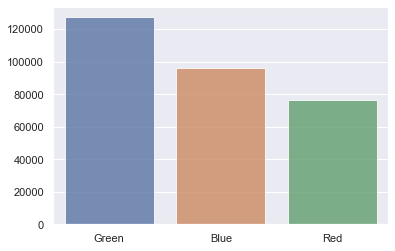

In [35]:
count=df['nom_0'].value_counts()
sns.set(style="darkgrid")
sns.barplot(count.index, count.values, alpha=0.8)

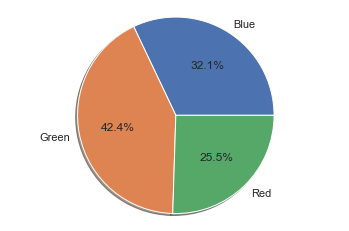

In [36]:
labels = df['nom_0'].astype('category').cat.categories.tolist()
counts = df['nom_0'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) 
ax1.axis('equal')
plt.show()

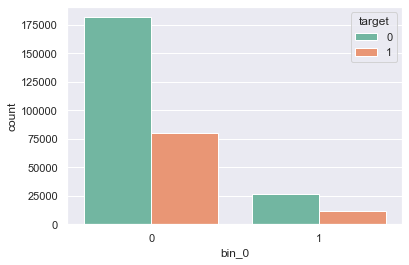

In [37]:
ax = sns.countplot(x='bin_0',hue='target',data=df,palette='Set2')

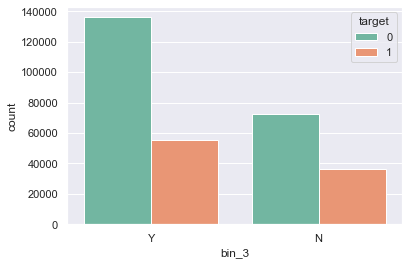

In [38]:
ax = sns.countplot(x='bin_3',hue='target',data=df,palette='Set2')

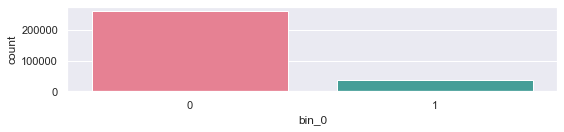

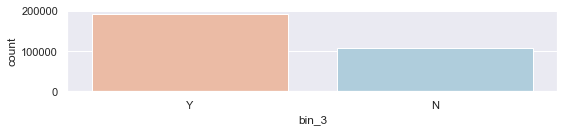

In [39]:
bin_cols = ['bin_0','bin_3']
palettes = ['husl','RdBu']
for n, col in enumerate(df[bin_cols]): 
    plt.figure(n,figsize=(8,2))
    ax = sns.countplot(x=col, data=df, palette=palettes[n])
    plt.tight_layout()

In [40]:
for col in df.columns[1:4]:
    print(col, df[col].nunique())

bin_0 2
bin_3 2
nom_0 3


In [41]:
train_targets = df.target
train_features = df.drop(['target'], axis=1)
percentage = train_targets.mean() * 100
print("The percentage of ones in the training target is {:.2f}%".format(percentage))
train_features.head()

The percentage of ones in the training target is 30.59%


,id,bin_0,bin_3,nom_0
0,0,0,Y,Green
1,1,0,Y,Green
2,2,0,Y,Blue
3,3,0,Y,Red
4,4,0,N,Red


In [42]:
columns = [col for col in train_features.columns if col != 'id']
woe_encoder = ce.WOEEncoder(cols=columns)
woe_encoded_train = woe_encoder.fit_transform(train_features[columns], train_targets).add_suffix('_woe')
train_features = train_features.join(woe_encoded_train)

woe_encoded_cols = woe_encoded_train.columns

C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [43]:
df1 = train_features.copy()
df1['target'] = train_targets

overall_number_of_ones = train_targets.sum()
overall_number_of_zeroes = 600000 - overall_number_of_ones
print("There are {} ones and {} zeroes in the training set".format(
    overall_number_of_ones, overall_number_of_zeroes
))

grouped = pd.DataFrame()
grouped['Total'] = df1.groupby('nom_0').id.count()
grouped['number of ones'] = df1.groupby('nom_0').target.sum()
grouped['number of zeroes'] = grouped['Total'] - grouped['number of ones']

grouped['percentage of ones'] = grouped['number of ones'] / overall_number_of_ones
grouped['percentage of zeroes'] = grouped['number of zeroes'] / overall_number_of_zeroes
grouped['(% ones) > (% zeroes)'] = grouped['percentage of ones'] > grouped['percentage of zeroes']

grouped['weight of evidence'] = df1.groupby('nom_0').nom_0_woe.mean()

grouped

There are 91764 ones and 508236 zeroes in the training set


,Total,number of ones,number of zeroes,percentage of ones,percentage of zeroes,(% ones) > (% zeroes),weight of evidence
nom_0,,,,,,,
Blue,96166,23252,72914,0.253389,0.143465,True,-0.323420
Green,127341,41659,85682,0.453980,0.168587,True,0.098327
Red,76493,26853,49640,0.292631,0.097671,True,0.205037


In [44]:
def logreg_test(cols, encoder):
    df = train_features[cols]
    auc_scores = []
    acc_scores = []
    
    skf = StratifiedKFold(n_splits=6, shuffle=True).split(df1, train_targets)
    for train_id, valid_id in skf:
        enc_tr = encoder.fit_transform(df.iloc[train_id,:], train_targets.iloc[train_id])
        enc_val = encoder.transform(df.iloc[valid_id,:])
        regressor = LogisticRegression(solver='lbfgs', max_iter=1000, C=0.6)
        regressor.fit(enc_tr, train_targets.iloc[train_id])
        acc_scores.append(regressor.score(enc_val, train_targets.iloc[valid_id]))
        probabilities = [pair[1] for pair in regressor.predict_proba(enc_val)]
        auc_scores.append(roc_auc_score(train_targets.iloc[valid_id], probabilities))
        
    acc_scores = pd.Series(acc_scores)
    mean_acc = acc_scores.mean() * 100
    print("Mean accuracy score: {:.3f}%".format(mean_acc))
    
    auc_scores = pd.Series(auc_scores)
    mean_auc = auc_scores.mean() * 100
    print("Mean AUC score: {:.3f}%".format(mean_auc))

##########################################
print("Using Weight of Evidence Encoder")
woe_encoder = ce.WOEEncoder(cols=columns)
logreg_test(columns, woe_encoder)

##########################################
print("\nUsing Target Encoder")
targ_encoder = ce.TargetEncoder(cols=columns, smoothing=0.2)
logreg_test(columns, targ_encoder)

##########################################
print("\nUsing CatBoost Encoder")
cb_encoder = ce.CatBoostEncoder(cols=columns)
logreg_test(columns, cb_encoder)

Using Weight of Evidence Encoder


C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\theja\anaconda3\lib\site-packages\category_encoders

Mean accuracy score: 69.412%
Mean AUC score: 56.555%

Using Target Encoder


C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\theja\anaconda3\lib\site-packages\category_encoders

Mean accuracy score: 69.412%
Mean AUC score: 56.555%

Using CatBoost Encoder


C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\theja\anaconda3\lib\site-packages\category_encoders

Mean accuracy score: 69.412%
Mean AUC score: 56.523%


C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


<AxesSubplot:>

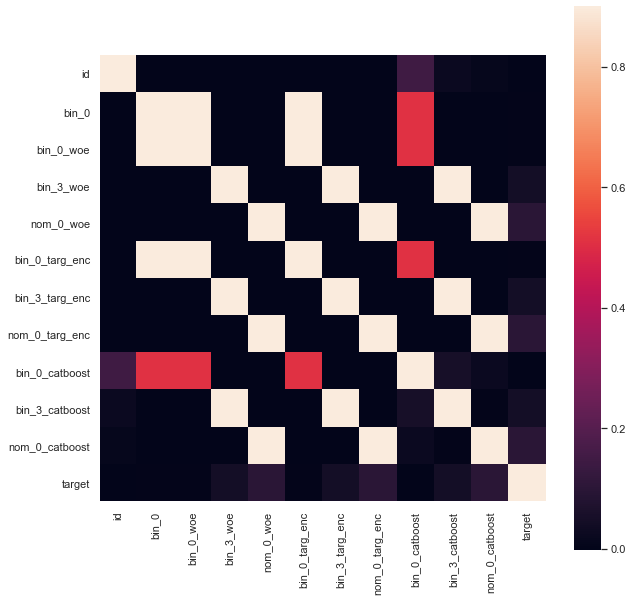

In [45]:
# Encode again, this time on the whole training set. WOEE was done above.
encoder = ce.TargetEncoder(cols=columns, smoothing=0.2)
encoded_train = encoder.fit_transform(train_features[columns], train_targets).add_suffix('_targ_enc')
train_features = train_features.join(encoded_train)

encoder = ce.CatBoostEncoder(cols=columns)
encoded_train = encoder.fit_transform(train_features[columns], train_targets).add_suffix('_catboost')
train_features = train_features.join(encoded_train)

training_set = train_features.copy()
training_set['target'] = train_targets
corrmat = training_set.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, vmax=0.9, square=True)

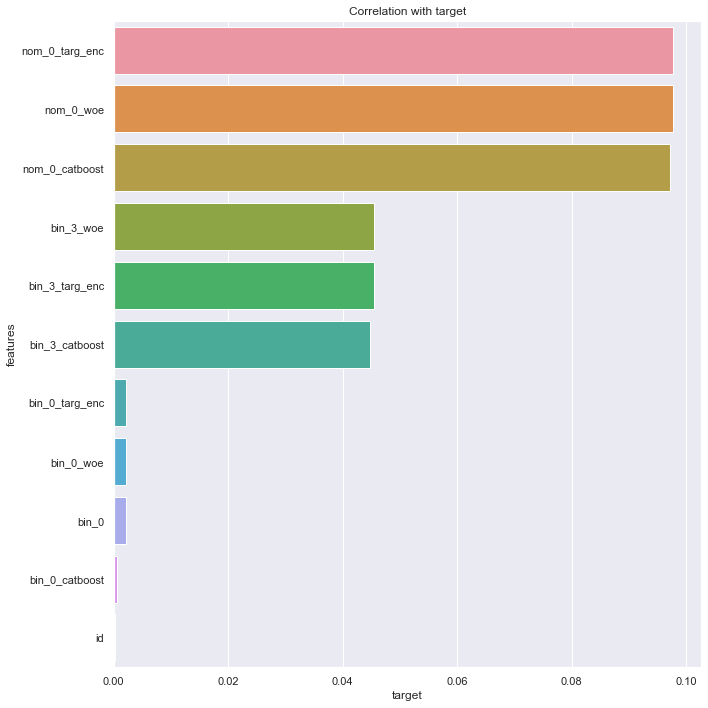

In [46]:
corr_with_target = corrmat['target'].apply(abs).sort_values(ascending=False)
corr_with_target.drop(['target'], inplace=True)
df = pd.DataFrame(data={'features': corr_with_target.index, 'target': corr_with_target.values})
plt.figure(figsize=(10,10))
sns.barplot(x="target", y="features", data=df)
plt.title('Correlation with target')
plt.tight_layout()
plt.show()

In [47]:
# Encoding training data
df1 = train_features[columns]
train_encoded = pd.DataFrame()
skf = StratifiedKFold(n_splits=5,shuffle=True).split(df1, train_targets)
for tr_in,fold_in in skf:
    encoder = ce.WOEEncoder(cols=columns)
    encoder.fit(df1.iloc[tr_in,:], train_targets.iloc[tr_in])
    train_encoded = train_encoded.append(encoder.transform(df1.iloc[fold_in,:]),ignore_index=False)

train_encoded = train_encoded.sort_index()

# Encoding test data
encoder = ce.WOEEncoder(cols=columns)
encoder.fit(df1, train_targets)
test_encoded = encoder.transform(test_features[columns])

# Fitting
regressor = LogisticRegression(solver='lbfgs', max_iter=1000, C=0.6)
regressor.fit(train_encoded, train_targets)

# Predicting
probabilities = [pair[1] for pair in regressor.predict_proba(test_encoded)]
output = pd.DataFrame({'id': test_features['id'],
                       'target': probabilities})
output.to_csv('submission.csv', index=False)
output.describe()

C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\theja\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\theja\anaconda3\lib\site-packages\category_encoders

,id,target
count,50456.000000,50456.000000
mean,250725.500000,0.305939
std,14565.536928,0.049661
min,225498.000000,0.227948
25%,238111.750000,0.266094
50%,250725.500000,0.310509
75%,263339.250000,0.335013
max,275953.000000,0.382206
